The goal of image denoising is to obtain the original image from the noisy image. We will take 10 clear images as input, add noise to them using numpy, and try to denoise them using non-local means and gaussian filter algorithms.

In [22]:
def show_gray(img,title=""):
  """
  Function to show grayscale image
  """
  plt.imshow(img,cmap='gray')
  plt.title(title)

**Downloading the Dataset**

In [23]:
#taken from this StackOverflow answer: https://stackoverflow.com/a/39225039
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
file_id = '1qqcwhDuhk7w9Lav1--kdNqm-Q5s3qvwn'
destination = '/content/dataset.zip'
download_file_from_google_drive(file_id, destination)

In [24]:
!unzip -q dataset.zip
!rm -rf dataset.zip

**Assumptions**
1. We have assumed that the target pixel's weights with respect to pixels outside of this search window are negligible.

2. We have tested on image 3, and assumed that the filtering parameter will give good results for the rest of the images as well.

In [25]:
import numpy as np
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio

def MSE(image1,image2):
  """ 
  Mean Squared Error
  :param image1: image1
  :param image2: image2
  :rtype: float
  :return: MSE value
  """
  mean_squared_error = np.square(np.subtract(image1.astype("float"), image2.astype("float"))).mean();
  
  return mean_squared_error;

def PSNR(image1, image2, peak=255):
  """ 
  Peak signal-to-noise ratio
  :param image1: image1
  :param image2: image2
  :param peak: max value of pixel 8-bit image (255)
  :rtype: float
  :return: PSNR value
  """
  peak_signal_noise_ratio = 10*np.log10(peak**2/MSE(image1, image2));

  return peak_signal_noise_ratio;

In [26]:
seed =  200

from skimage.metrics import mean_squared_error, peak_signal_noise_ratio

np.random.seed(seed)
image1 = np.random.randint(0,256,(1280,720,3))
image2 = np.random.randint(0,256,(1280,720,3))

print(f"Skimage -> PSNR: {peak_signal_noise_ratio(image1,image2,data_range=255):.4f} | MSR: {mean_squared_error(image1,image2):.4f}")
print(f"My Func -> PSNR: {PSNR(image1,image2):.4f} | MSR: {MSE(image1,image2):.4f}")

Skimage -> PSNR: 7.7475 | MSR: 10922.7525
My Func -> PSNR: 7.7475 | MSR: 10922.7525


**Creating Noisy Images**
<br>
Salt n Pepper Noise: 
More information [here](https://en.wikipedia.org/wiki/Salt-and-pepper_noise).

Gaussian Noise: 
More information [here](https://en.wikipedia.org/wiki/Gaussian_noise). 



In [27]:
from skimage.util import random_noise
import numpy as np

class NoisySystem():
  def example(self,img,**kwargs):
    """
    An example function to test expected return.
    You can read more about skimage.util.random_noise at https://scikit-image.org/docs/dev/api/skimage.util.html#skimage.util.random_noise
    """
    noisy_image = random_noise(img,**kwargs)
    noisy_image = np.uint8(noisy_image*255)
    return noisy_image

  def create_salt_and_pepper_noise(self,img,amount=0.05):
    """
    function to create salt and pepper noise
    :param image: input image
    :rtype: uint8 (w,h)
    :return: noisy image
    
    """
    image = np.copy(img)                            # copying the original image to introduce salt and pepper noise
    height, width = image.shape                     # dimensions

    noisy_pixels = round(amount*height*width*0.5)   # number of pixels to be changed = amount*total no. of pixels, 
                                                    # where total number of pixels = width*height
                                                    # 0.5 factor was added to bring the MSE in the +-200 range
    while(noisy_pixels>0):
        y1 = np.random.randint(0, height-1)         # y coordinate of pixel to be set to white
        y2 = np.random.randint(0, height-1)         # y coordinate of pixel to be set to black
        x1 = np.random.randint(0, width-1)          # x coordinate of pixel to be set to white
        x2 = np.random.randint(0, width-1)          # x coordinate of pixel to be set to black
      
        image[y1][x1] = 255         # set pixel to white
        image[y2][x2] = 0           # set pixel to black
        noisy_pixels -= 1


    return image

  def create_gaussian_noise(self,img,mean=0,var=0.01):
    """
    function to create gaussian noise
    :param image: input image
    :rtype: uint8 (w,h)
    :return: noisy image
    """
    
    image = np.copy(img)                   # create copy of input image
    height, width = image.shape            # dimensions

    noise = 255*np.random.normal(mean, (var**0.5), (height, width))    # apply gaussian distribution
    
    image = image + noise         # add noise to image  

    return image

Total Time taken: 0.95s

Statistics:
Example   => SNP -> PSNR: 16.64 | MSE: 1411.06
Example   => GSN -> PSNR: 21.97 | MSE: 413.00
My Func   => SNP -> PSNR: 16.76 | MSE: 1371.20
My Func   => GSN -> PSNR: 20.00 | MSE: 650.36


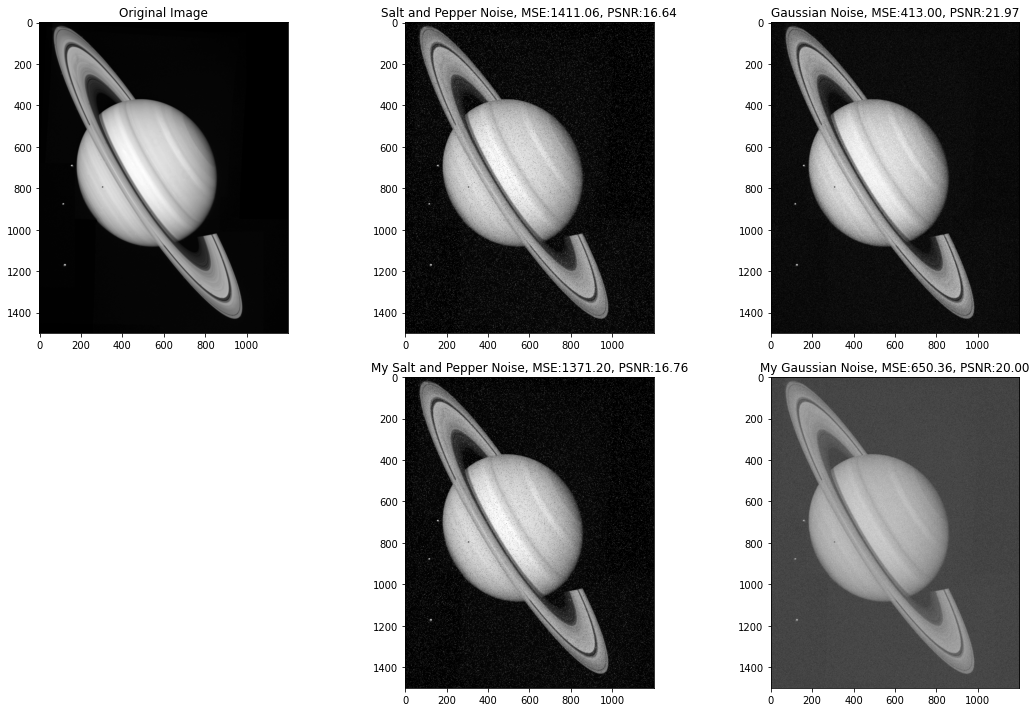

In [28]:
image_number = 8
%matplotlib inline
import cv2
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

clear_output(wait=True)

start = time.time()

noise_maker               = NoisySystem()
image                     = cv2.imread(f"/content/dataset/Image{image_number}.png")
image                     = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

salt_and_pepper_example   = noise_maker.example(image.copy(),mode="s&p")
gaussian_example          = noise_maker.example(image.copy(),mode="gaussian")
salt_and_pepper_image     = noise_maker.create_salt_and_pepper_noise(image.copy())
gaussian_image            = noise_maker.create_gaussian_noise(image.copy())

end = time.time()
print(f"Total Time taken: {end-start:.2f}s\n")
print("Statistics:")
print(f"Example   => SNP -> PSNR: {PSNR(salt_and_pepper_example,image):.2f} | MSE: {MSE(salt_and_pepper_example,image):.2f}")
print(f"Example   => GSN -> PSNR: {PSNR(gaussian_example,image):.2f} | MSE: {MSE(gaussian_example,image):.2f}")
print(f"My Func   => SNP -> PSNR: {PSNR(salt_and_pepper_image,image):.2f} | MSE: {MSE(salt_and_pepper_image,image):.2f}")
print(f"My Func   => GSN -> PSNR: {PSNR(gaussian_image,image):.2f} | MSE: {MSE(gaussian_image,image):.2f}")


fig = plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
show_gray(image,"Original Image")
plt.subplot(2,3,2)
show_gray(salt_and_pepper_example,
          f"Salt and Pepper Noise, MSE:{MSE(image,salt_and_pepper_example):.2f}, PSNR:{PSNR(image,salt_and_pepper_example):.2f}")
plt.subplot(2,3,3)
show_gray(gaussian_example,
          f"Gaussian Noise, MSE:{MSE(image,gaussian_example):.2f}, PSNR:{PSNR(image,gaussian_example):.2f}")
plt.subplot(2,3,5)
show_gray(salt_and_pepper_image,
          f"My Salt and Pepper Noise, MSE:{MSE(image,salt_and_pepper_image):.2f}, PSNR:{PSNR(image,salt_and_pepper_image):.2f}")
plt.subplot(2,3,6)
show_gray(gaussian_image,
          f"My Gaussian Noise, MSE:{MSE(image,gaussian_image):.2f}, PSNR:{PSNR(image,gaussian_image):.2f}")
fig.tight_layout()
plt.show()

Non Local Means denoiser.

In [29]:
# class NLMeans():
#   """
#   Non Local Means, donot change the solve function. You may add any other class 
#   functions or other functions in the colab file. but refrain for function/class
#   definitions already given. These will be used to grade later on.
#   """
#   def example(self,img,**kwargs):
#     denoised_image = cv2.fastNlMeansDenoising(img,**kwargs)
#     return denoised_image
  
#   def euclideanDist(self,x,y,small_window=7):
#     x = x.reshape(small_window**2,1)
#     y = y.reshape(small_window**2,1)
#     return (np.sum(np.square(np.subtract(x,y))))


#   def Z(self,i_x,i_y,h,small_window,big_window,img_b):
#     sub_img = self.k_neighbourhood(i_x, i_y, big_window, img_b)
#     v_N_i = self.k_neighbourhood(i_x, i_y, small_window, img_b)
#     sum=0
#     for a in range(len(sub_img)):
#       for b in range(len(sub_img[0])):
#         v_N_j = self.k_neighbourhood(a+13, b+13, small_window, img_b)
#         sum+=np.exp(-(self.euclideanDist(v_N_i,v_N_j)/h**2))
#     return sum    
  
#   def weights(self,i_x,i_y,j_x,j_y,h,small_window,big_window,img_b):
#     v_N_i = self.k_neighbourhood(i_x, i_y, small_window, img_b)
#     v_N_j = self.k_neighbourhood(j_x, j_y, small_window, img_b) 
#     Z_i = self.Z(i_x,i_y,h,small_window,big_window,img_b)
#     weight = ((np.exp(-(self.euclideanDist(v_N_i,v_N_j)/h**2)))/Z_i)
#     return weight
  
#   def k_neighbourhood(self, x, y, window, img_b):
#     neighbourhood = img_b[(x-(window//2)):(x+(window//2)+1), (y-(window//2)):(y+(window//2)+1)]
#     return neighbourhood

#   def solve(self,img,h=30,small_window=7,big_window=21):
#     """
#     Solve function to perform nlmeans filtering.

#     :param img: noisy image
#     :param h: sigma h (as mentioned in the paper)
#     :param small_window: size of small window
#     :param big_window: size of big window
#     :rtype: uint8 (w,h)
#     :return: solved image
#     """

#     image = np.copy(img)
#     width, height = image.shape

#     # Add padding
#     bt = 13
#     image_padding = cv2.copyMakeBorder(image, bt, bt, bt, bt, cv2.BORDER_CONSTANT, value=(0,0,0))

#     NL = np.zeros((width*height))

#     # O ( 49 x 441 x w x h )
#     for i in range(width*height):
#       i_x, i_y = (i//width)+bt, (i%width)+bt
#       for j in range(big_window**2):
#         # print("Iteration (i, j):",i,j)
#         j_x, j_y = (i_x-(big_window//2)), (i_y-(big_window//2))
#         # print("jx,jy ",j_x,j_y)       
#         NL[i] += self.weights(i_x,i_y,j_x,j_y,h,small_window,big_window,image_padding)*image[j_x][j_y]
#         j_x += j//big_window
#         j_y += j%big_window
        

#     NL = NL.reshape(width, height)
#     return NL


The Non-Local Means Algorithm code, without any vectorization or efficiency enhancement, is contained in the class above. This code is not used since it has a high time complexity of the order of O(49 x 441 x height x width). Instead, we apply a vectorized version of the Non-Local Means technique, which has a O(height x width) time complexity.

In [30]:
class NLMeans():
  """
  Non Local Means, donot change the solve function. You may add any other class 
  functions or other functions in the colab file. but refrain for function/class
  definitions already given. These will be used to grade later on.
  """
  def example(self,img,**kwargs):
    denoised_image = cv2.fastNlMeansDenoising(img,**kwargs)
    return denoised_image
  
  def euclideanDist(self,x,y):
    """
    Returns a vector of euclidean distances between x and y
    """
    return np.sqrt(np.sum(np.square(np.subtract(x,y)), axis=2))

  def k_neighbourhood(self, x, y, window, img_padded):
    h, w, c = img_padded.shape
    size = window//2
    neighbourhood = np.zeros((window, window, c))
    x_min, x_max = max(0, x-size), min(w, x+size+1)
    y_min, y_max = max(0, y-size), min(h, y+size+1)

    neighbourhood[size - (y-y_min):size + (y_max-y), size - (x-x_min):size + (x_max-x)] = img_padded[y_min:y_max, x_min:x_max]   # Size of neighbourhood submatrix

    return neighbourhood

  def k_neighbourhood_vectorized(self, small_window, big_window, img, img_padded):
    """
    Vectorized implementation of function to find the smaller window for each pixel in the bigger window
    """
    height, width = img.shape
    neighbourhood = np.zeros((height+big_window-1, width+big_window-1, small_window, small_window))

    for y in range(height+big_window-1):
      for x in range(width+big_window-1):
        neighbourhood[y, x] = np.squeeze(self.k_neighbourhood((x+((small_window-1)//2)), (y+((small_window-1)//2)),
                                                              small_window, img_padded[:, :, np.newaxis]))
    return neighbourhood

  def solve(self,img,h=30,small_window=7,big_window=21):
    """
    Solve function to perform nlmeans filtering.

    :param img: noisy image
    :param h: sigma h (as mentioned in the paper)
    :param small_window: size of small window
    :param big_window: size of big window
    :rtype: uint8 (w,h)
    :return: solved image
    """

    image = np.copy(img)
    height, width = image.shape

    # Add padding
    bt = ((big_window//2) + (small_window//2))
    image_padding = np.pad(image, bt)

    # Find the matrix of each small neighbourhood in the larger search window
    neighbourhood = self.k_neighbourhood_vectorized(small_window, big_window, image, image_padding)

    # Define output matrix of the same shape as original image
    out = np.zeros((height,width))

    for Y in range(height):
      for X in range(width):
        # Add correction in coordinates
        x, y = X + (big_window//2), Y + (big_window//2)

        # print("Iteration (X, Y, x, y): ",X,Y,x,y)

        # Get submatrix around pixel j
        img1 = np.reshape(neighbourhood, (height+big_window-1, width+big_window-1, small_window*small_window))
        v_N_j = self.k_neighbourhood(x, y, big_window, img1)
        
        # Get submatrix around pixel i
        v_N_i = neighbourhood[y, x].flatten()

        # Find the exponential term that will be used later
        exp_term = np.exp(-(self.euclideanDist(v_N_i, v_N_j))/(h**2))

        # Find Z by summing the exponential terms over all j's
        Z = np.sum(exp_term)

        # Calculating average pixel value
        im_part = np.squeeze(self.k_neighbourhood(x+((small_window-1)//2), y+((small_window-1)//2), big_window, image_padding[:, :, None]))

        # Find the numerator of weight corresponding to current pixel
        NL = np.sum(exp_term*im_part)

        # Final output pixel
        out[Y, X] = NL/Z

    return out

(Inbuilt) Time taken: 0.20s

(My function) Time taken: 18.87s

Statistics:
salt_and_paper_h: 30 , gaussian_h: 33

Noisy   => SNP -> PSNR: 17.87 | MSE: 1062.74
Noisy   => GSN -> PSNR: 20.26 | MSE: 612.65
Skimage => SNP -> PSNR: 26.89 | MSE: 132.96
Skimage => GSN -> PSNR: 28.73 | MSE: 87.10
My Func => SNP -> PSNR: 20.97 | MSE: 519.61
My Func => GSN -> PSNR: 21.06 | MSE: 509.03



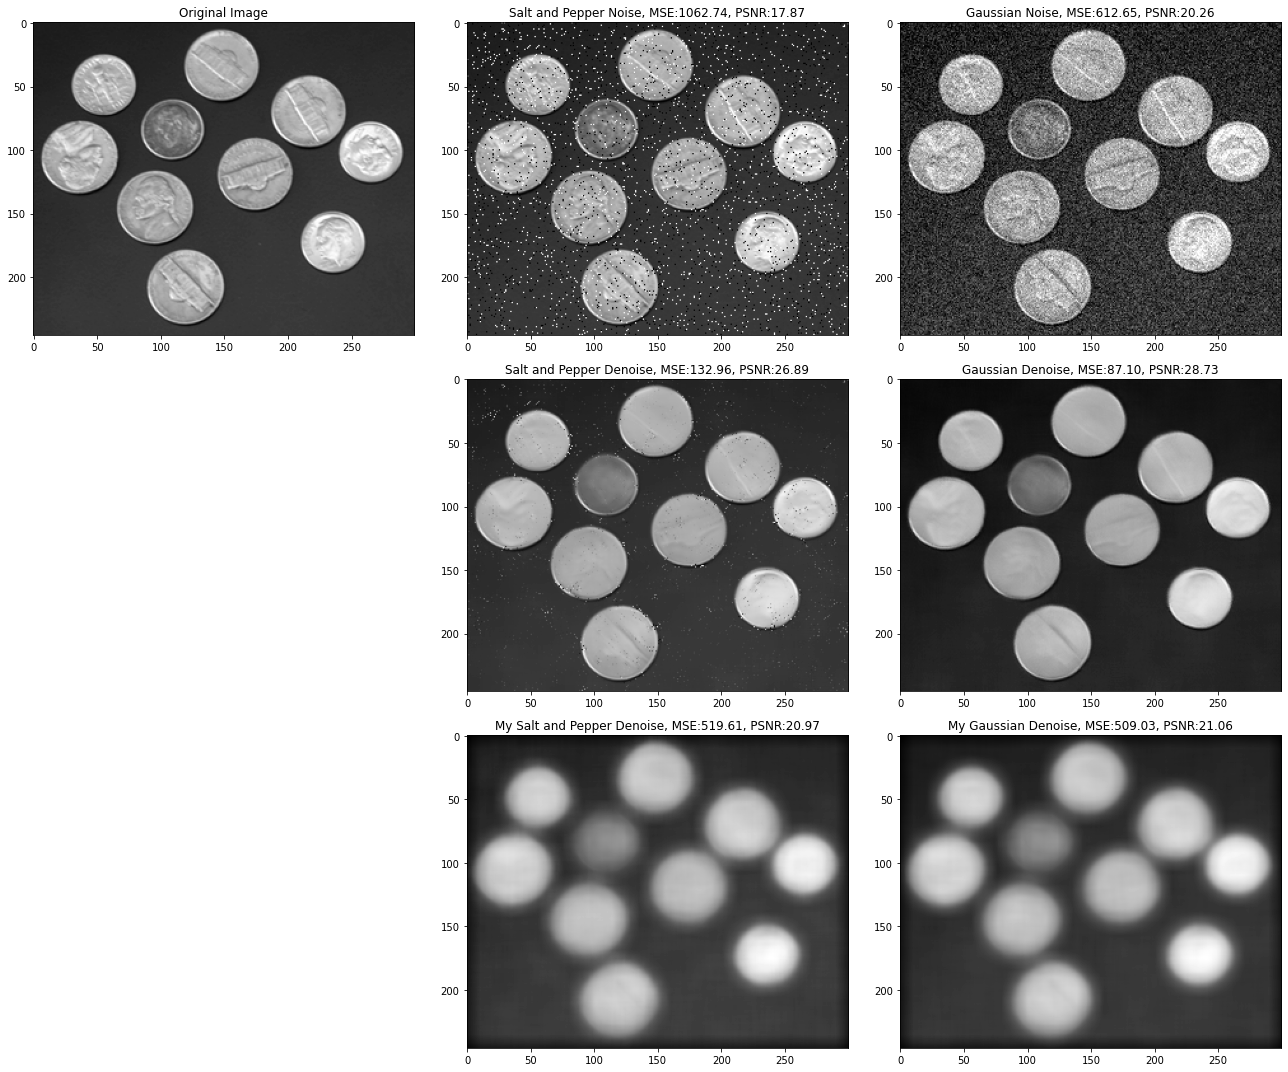

In [31]:
image_number = 4 
salt_and_paper_h = 30
gaussian_h = 33  

%matplotlib inline
import cv2
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
 
clear_output(wait=True)
 
 
denoiser                    = NLMeans()
image                       = cv2.imread(f"/content/dataset/Image{image_number}.png")
image                       = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
 
salt_and_pepper_example     = noise_maker.example(image.copy(),mode="s&p")
gaussian_example            = noise_maker.example(image.copy(),mode="gaussian")
 
start = time.time()
 
salt_and_pepper_denoise     = denoiser.example(salt_and_pepper_example.copy(),h=salt_and_paper_h)
gaussian_denoise            = denoiser.example(gaussian_example.copy(),h=gaussian_h)
 
end = time.time()
print(f"(Inbuilt) Time taken: {end-start:.2f}s\n")
 
start = time.time()
 
my_salt_and_pepper_denoise  = denoiser.solve(salt_and_pepper_example.copy(),h=salt_and_paper_h)
my_gaussian_denoise         = denoiser.solve(gaussian_example.copy(),h=gaussian_h)
 
end = time.time()
print(f"(My function) Time taken: {end-start:.2f}s\n")
 
print("Statistics:")
print(f"salt_and_paper_h: {salt_and_paper_h} , gaussian_h: {gaussian_h}\n")
print(f"Noisy   => SNP -> PSNR: {PSNR(salt_and_pepper_example,image):.2f} | MSE: {MSE(salt_and_pepper_example,image):.2f}")
print(f"Noisy   => GSN -> PSNR: {PSNR(gaussian_example,image):.2f} | MSE: {MSE(gaussian_example,image):.2f}")
print(f"Skimage => SNP -> PSNR: {PSNR(salt_and_pepper_denoise,image):.2f} | MSE: {MSE(salt_and_pepper_denoise,image):.2f}")
print(f"Skimage => GSN -> PSNR: {PSNR(gaussian_denoise,image):.2f} | MSE: {MSE(gaussian_denoise,image):.2f}")
print(f"My Func => SNP -> PSNR: {PSNR(my_salt_and_pepper_denoise,image):.2f} | MSE: {MSE(my_salt_and_pepper_denoise,image):.2f}")
print(f"My Func => GSN -> PSNR: {PSNR(my_gaussian_denoise,image):.2f} | MSE: {MSE(my_gaussian_denoise,image):.2f}\n")
 
fig = plt.figure(figsize=(18,15))
plt.subplot(3,3,1)
show_gray(image,"Original Image")
plt.subplot(3,3,2)
show_gray(salt_and_pepper_example,
          f"Salt and Pepper Noise, MSE:{MSE(image,salt_and_pepper_example):.2f}, PSNR:{PSNR(image,salt_and_pepper_example):.2f}")
plt.subplot(3,3,3)
show_gray(gaussian_example,
          f"Gaussian Noise, MSE:{MSE(image,gaussian_example):.2f}, PSNR:{PSNR(image,gaussian_example):.2f}")
plt.subplot(3,3,5)
show_gray(salt_and_pepper_denoise,
          f"Salt and Pepper Denoise, MSE:{MSE(image,salt_and_pepper_denoise):.2f}, PSNR:{PSNR(image,salt_and_pepper_denoise):.2f}")
plt.subplot(3,3,6)
show_gray(gaussian_denoise,
          f"Gaussian Denoise, MSE:{MSE(image,gaussian_denoise):.2f}, PSNR:{PSNR(image,gaussian_denoise):.2f}")
plt.subplot(3,3,8)
show_gray(my_salt_and_pepper_denoise,
          f"My Salt and Pepper Denoise, MSE:{MSE(image,my_salt_and_pepper_denoise):.2f}, PSNR:{PSNR(image,my_salt_and_pepper_denoise):.2f}")
plt.subplot(3,3,9)
show_gray(my_gaussian_denoise,
          f"My Gaussian Denoise, MSE:{MSE(image,my_gaussian_denoise):.2f}, PSNR:{PSNR(image,my_gaussian_denoise):.2f}")
fig.tight_layout()
plt.show()

**Methodology of the non-Local means algorithm**

1. We start by padding the image so that each pixel has a 7x7 and 21x21 neighbourhood. The border thickness comes out to be (7-1)/2 + (21-1)/2 = 13.

2. Next we create the neighbourhood matrix, which stores the 7x7 neighbourhoods for all the pixels. We will need to iterate through these 7x7 neighbourhood pixels for each ixel while denoising. 

3. We now iterate though all the pixels of the image. For each pixel i, there are 21×21 = 441 j’s (the pixels in the search window). For each pixel j in the search window, there is another neighbourhood of 7x7. These 441 neighbourhoods are defined by v(Nj) for each j. The 7x7 neighbourhood around pixel i is defined by v(Ni).

4. The weights corresponding to each pair of (i, j) is calculated.

5. The final gray value of the traget pixel is determined using the weights. This is the final pixel in the output image. Hence after iterating to all the pixels, we get a final denoised output image.

**Significance of the sigma\_h, small\_window and big\_window parameters**

###sigma_h###
1. This is the Degree of Filtering. It is the factor by which the exponential function decays, hence it controls how fast the weights decay.

2. The default value of h is 10 × σ, where σ is the standard deviation of the noisy image.

3. If h is large, the function will decay real quick, hence the denoised value of a given pixel will have less dependence on weights of far off pixels, and vice versa.

###small_window###
1. This is the side length of the square sliding window, over which we will
compute the average value of that pixel. The similarity square neighbourhood Ni has the size small_window × small_window.

2. Default value of small_window is 7. 7 has been fixed because it is not so large so it will take into account the fine details of the image, but large enough to be robust to noise. Taking large value will make us take mean over a large square, and we may end up loosing some fine details of the original image. Taking a very small value will make the algorithm beleive that the noisy pixel is also a fine detail of the image. So noisy pixels might show up in the output.

###big_window###

1. This is the side length of the square search window over which we search for similarity. The window has size big_window*big_window.

2. The default value of big_window is 21.

3. Instead of calculating the distance of the average of the current pixel with every other pixel in the image, we calculate its distance with every pixel inside this square search window.




### Metrics (MSE and PSNR) obtained 
Generated using [this](https://www.tablesgenerator.com/markdown_tables).

| Image Number | Type of Noise |     Noisy Image    |                    | Denoised Image using NLM |                    | Denoised Image using Gaussian Filter |                    |
|:------------:|:-------------:|:------------------:|:------------------:|:------------------------:|:------------------:|:------------------------------------:|:------------------:|
|              |               |        PSNR        |         MSE        |           PSNR           |         MSE        |                 PSNR                 |         MSE        |
|       1      |      SNP      | 18.000668388119948 | 1030.4182027180989 | 28.012929679187074       | 102.75131602034232 | 18.000668388119948                   | 1030.4182027180989 |
|              |      GSN      | 19.975287949086425 | 653.9605734098009  | 30.15359516750147        | 62.76547850712433  | 19.975287949086425                   | 653.9605734098009  |
|       2      |      SNP      | 18.179323424513697 | 988.8900756873649  | 23.207498601010105       | 310.69230762344966 | 18.179323424513697                   | 988.8900756873649  |
|              |      GSN      | 19.97939257336665  | 653.3427911265969  | 25.414326500732297       | 186.91653034421796 | 19.97939257336665                    | 653.3427911265969  |
|       3      |      SNP      | 18.22398409581661  | 978.7729339599609  | 24.616823362242247       | 224.59393519367728 | 18.22398409581661                    | 978.7729339599609  |
|              |      GSN      | 20.027158273655566 | 646.196398951511   | 26.86665544081679        | 133.78727769126846 | 20.027158273655566                   | 646.196398951511   |
|       4      |      SNP      | 17.85823935520002  | 1064.7715176151762 | 26.265606637923984       | 153.64544764033886 | 17.85823935520002                    | 1064.7715176151762 |
|              |      GSN      | 19.990839597967703 | 651.6229941430123  | 28.221114671034716       | 97.94198321915361  | 19.990839597967703                   | 651.6229941430123  |
|       5      |      SNP      | 16.733879993894746 | 1379.4067965003173 | 27.349462009084682       | 119.71102791839428 | 16.733879993894746                   | 1379.4067965003173 |
|              |      GSN      | 19.98796474012049  | 652.0544856139186  | 32.89007525304874        | 33.42510926037364  | 19.98796474012049                    | 652.0544856139186  |
|       6      |      SNP      | 18.092752400060828 | 1008.8001098632812 | 22.932395441079688       | 331.0097732543596  | 18.092752400060828                   | 1008.8001098632812 |
|              |      GSN      | 20.01118886929885  | 648.5768960407083  | 25.44605750107699        | 185.55583286804915 | 20.01118886929885                    | 648.5768960407083  |
|       7      |      SNP      | 17.13018280324222  | 1259.1053826745165 | 24.474616824750626       | 232.06982694105125 | 17.13018280324222                    | 1259.1053826745165 |
|              |      GSN      | 19.9331116583172   | 660.342417036042   | 27.352449932991743       | 119.62869566647781 | 19.9331116583172                     | 660.342417036042   |
|       8      |      SNP      | 16.75178212474204  | 1373.732422222222  | 28.53755518708608        | 91.0594121169245   | 16.75178212474204                    | 1373.732422222222  |
|              |      GSN      | 19.998487119028553 | 650.4765564632327  | 37.62156036148586        | 11.244090300018803 | 19.998487119028553                   | 650.4765564632327  |
|       9      |      SNP      | 17.69357202733182  | 1105.9185892740886 | 27.869661359113216       | 106.19748333199686 | 17.69357202733182                    | 1105.9185892740886 |
|              |      GSN      | 19.998623695741397 | 650.4561006304594  | 30.7221159091613         | 55.06412848944924  | 19.998623695741397                   | 650.4561006304594  |
|      10      |      SNP      | 18.41389433609049  | 936.8950130208333  | 22.376137537634232       | 376.2414219588576  | 18.41389433609049                    | 936.8950130208333  |
|              |      GSN      | 19.998651208816685 | 650.4519799262532  | 24.48773349943242        | 231.36998100379748 | 19.998651208816685                   | 650.4519799262532  |


1. We observe that successfully denoise the image, as there is a significant improvement in PSNR values.

2. We observe that the NLM denoiser gives
better results in 6/10 salt and pepper noisy images and 7/10 gaussian noisy images. 

3. While the Gaussian Filter simply tries to smooth out the image and minimise the noise instead of removing it, the Non-Local Means Algorithm attempts to remove the noise by comparing with its surrounding pixels. Therefore the NLM algorithm is comparitively better.







**Comparison between NL Means denoising and Gaussian Denoising.**

In [32]:
class GaussianFilter():
  """
  GaussianFilter, donot change the solve function. You may add any other class 
  functions or other functions in the colab file. but refrain for function/class
  definitions already given. These will be used to grade later on.
  """

  def solve(self, img, ksize=(5,5), sigma_x=0):
    """
    Solve function to perform gaussian filtering.

    :param img: noisy image
    :param ksize: representing the size of the kernel.
    :param sigma_x: standard deviation in X direction
    :rtype: uint8 (w,h)
    :return: solved image
    """ 
    img_out = np.zeros(img.shape)
    img_out = cv2.GaussianBlur(img,ksize,sigma_x)
    
    return img

In [33]:
import csv
def comp(salt_and_paper_h,gaussian_h,image_number):
  """
  Function to compare the MSE and PSNR values of the two denoising algorithms:
  Non-Local Means and Gaussian Filter for Image{image_number}
  """
  # Initialize the two denoisers
  denoiser_nlm = NLMeans()
  denoiser_gsf = GaussianFilter()

  # Read the images
  image = cv2.imread(f"/content/dataset/Image{image_number}.png")
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Add 2 types of noise to the image and store these 2 new images
  salt_and_pepper_image = noise_maker.create_salt_and_pepper_noise(image.copy())
  gaussian_image        = noise_maker.create_gaussian_noise(image.copy())

  # Perform Non-Local Means denoising algorithm on both images
  print(f"NLM denoising beginning for image {image_number}")
  start = time.time()
  nlm_salt_and_pepper_denoise = denoiser_nlm.solve(salt_and_pepper_image.copy(),h=salt_and_paper_h)
  nlm_gaussian_denoise        = denoiser_nlm.solve(gaussian_image.copy(),h=gaussian_h)
  end = time.time()
  print(f"NLM denoising completed for image {image_number} in {end-start:.2f}s.")

  # Perform Gaussian Filtering on both images 
  print(f"Gaussian Filtering beginning for image {image_number}...")
  start = time.time()
  gsf_salt_and_pepper_denoise = denoiser_gsf.solve(salt_and_pepper_image.copy())
  gsf_gaussian_denoise        = denoiser_gsf.solve(gaussian_image.copy())
  end = time.time()
  print(f"Gaussian Filtering completed for image {image_number} in {end-start:.2f}s")

  Noisy_SNP_PSNR = PSNR(salt_and_pepper_image,image)
  Noisy_GSN_PSNR = PSNR(gaussian_image,image)
  NLM_SNP_PSNR = PSNR(nlm_salt_and_pepper_denoise,image)
  NLM_GSN_PSNR = PSNR(nlm_gaussian_denoise,image)
  GSF_SNP_PSNR = PSNR(gsf_salt_and_pepper_denoise,image)
  GSF_GSN_PSNR = PSNR(gsf_gaussian_denoise,image)
  
  Noisy_SNP_MSE = MSE(salt_and_pepper_image,image)
  Noisy_GSN_MSE = MSE(gaussian_image,image)
  NLM_SNP_MSE = MSE(nlm_salt_and_pepper_denoise,image)
  NLM_GSN_MSE = MSE(nlm_gaussian_denoise,image)
  GSF_SNP_MSE = MSE(gsf_salt_and_pepper_denoise,image)
  GSF_GSN_MSE = MSE(gsf_gaussian_denoise,image)

  row1 = [Noisy_SNP_PSNR, Noisy_SNP_MSE, NLM_SNP_PSNR, NLM_SNP_MSE, GSF_SNP_PSNR, GSF_SNP_MSE]
  row2 = [Noisy_GSN_PSNR, Noisy_GSN_MSE, NLM_GSN_PSNR, NLM_GSN_MSE, GSF_GSN_PSNR, GSF_GSN_MSE]

  # out_file = open("out.csv", "wb")

  with open("out.csv", 'a') as f_object:
    writer_object = csv.writer(f_object)
    writer_object.writerow(row1)
    writer_object.writerow(row2)
  
    f_object.close()


  # Print out all the PSNR and MSE values for the noisy and the two denoised algorithms
  print(f"Noisy   => SNP -> PSNR: {PSNR(salt_and_pepper_image,image):.2f} | MSE: {MSE(salt_and_pepper_image,image):.2f}")
  print(f"Noisy   => GSN -> PSNR: {PSNR(gaussian_image,image):.2f} | MSE: {MSE(gaussian_image,image):.2f}")
  print(f"NLM     => SNP -> PSNR: {PSNR(nlm_salt_and_pepper_denoise,image):.2f} | MSE: {MSE(nlm_salt_and_pepper_denoise,image):.2f}")
  print(f"NLM     => GSN -> PSNR: {PSNR(nlm_gaussian_denoise,image):.2f} | MSE: {MSE(nlm_gaussian_denoise,image):.2f}")
  print(f"GSF     => SNP -> PSNR: {PSNR(gsf_salt_and_pepper_denoise,image):.2f} | MSE: {MSE(gsf_salt_and_pepper_denoise,image):.2f}")
  print(f"GSF     => GSN -> PSNR: {PSNR(gsf_gaussian_denoise,image):.2f} | MSE: {MSE(gsf_gaussian_denoise,image):.2f}\n")
  print()
  print()
 
def compare(n,rnge="",salt_and_paper_h=10,gaussian_h=9):
  """
  Function to use the comp function in 2 ways.
  If rnge param is equal to "range", then all images from image_number 1 upto n will be compared
  Else, only the nth image will be compared 
  """
  if (rnge!=""):
    for image_number in range(1,n+1):
      comp(salt_and_paper_h,gaussian_h,image_number)
  else:
    comp(salt_and_paper_h,gaussian_h,n)


In [34]:
# Input the image number for which you want to compare both the denoisers in the compare() function as the argument
compare(4)

NLM denoising beginning for image 4
NLM denoising completed for image 4 in 18.11s.
Gaussian Filtering beginning for image 4...
Gaussian Filtering completed for image 4 in 0.00s
Noisy   => SNP -> PSNR: 17.83 | MSE: 1072.62
Noisy   => GSN -> PSNR: 19.99 | MSE: 651.95
NLM     => SNP -> PSNR: 26.40 | MSE: 149.00
NLM     => GSN -> PSNR: 28.22 | MSE: 97.98
GSF     => SNP -> PSNR: 17.83 | MSE: 1072.62
GSF     => GSN -> PSNR: 19.99 | MSE: 651.95





##References:##

1. https://ieeexplore.ieee.org/abstract/document/1467423/
2. https://en.wikipedia.org/wiki/Non-local_means
3. https://hal.archives-ouvertes.fr/hal-00512801v3/document
4. Did this as an assignment for ES331, Probability and Random Processes, in IIT Gandhinagar, and the code template was given to us. We only needed to implement the functions.